In [1]:
DATA_FOLDER = 'data/'

In [2]:
# Loading raw training labels
import numpy as np
import os

raw_train_labels = np.loadtxt(os.path.join(DATA_FOLDER, 'train.csv'), skiprows=1, dtype=[('filename','U15'),('whale_id','U15')], delimiter=",")
print('Raw labels:', raw_train_labels[:10])

Raw labels: [('0000e88ab.jpg', 'w_f48451c') ('0001f9222.jpg', 'w_c3d896a')
 ('00029d126.jpg', 'w_20df2c5') ('00050a15a.jpg', 'new_whale')
 ('0005c1ef8.jpg', 'new_whale') ('0006e997e.jpg', 'new_whale')
 ('000a6daec.jpg', 'w_dd88965') ('000f0f2bf.jpg', 'new_whale')
 ('0016b897a.jpg', 'w_64404ac') ('001c1ac5f.jpg', 'w_a6f9d33')]


In [3]:
# Removing 'new_whale' from training set, so we can train only on known whales
train_labels = raw_train_labels[raw_train_labels['whale_id'] != 'new_whale']
print('Known labels:', train_labels[:10])

Known labels: [('0000e88ab.jpg', 'w_f48451c') ('0001f9222.jpg', 'w_c3d896a')
 ('00029d126.jpg', 'w_20df2c5') ('000a6daec.jpg', 'w_dd88965')
 ('0016b897a.jpg', 'w_64404ac') ('001c1ac5f.jpg', 'w_a6f9d33')
 ('001cae55b.jpg', 'w_581ba42') ('00355ff28.jpg', 'w_cb622a2')
 ('00357e37a.jpg', 'w_d3b46e7') ('00442c882.jpg', 'w_8cad422')]


In [4]:
# Loading train set filenames
from glob import iglob

files_with_known_whales = train_labels['filename'].tolist()
train_filenames = [name.split(os.sep)[-1] for name in iglob(os.path.join(DATA_FOLDER, 'train', '*'))]
train_filenames = [name for name in train_filenames if name in files_with_known_whales]

assert len(train_filenames) == len(train_labels['filename'])

print('# of training examples:', len(train_filenames))

# of training examples: 15697


In [5]:
# Defining function to show images represented as numpy arrays
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [6]:
from sklearn.preprocessing import normalize

def get_large_contour(filename):
    """
    Returns the largest contour found in the image
    @param filename: path to the image file
    """
    
    # Read the image as-is
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    
    # Blur BGR images and convert to grayscale
    if len(img.shape) == 3:
        img = cv2.GaussianBlur(img, (11, 11), 0)
        # img = cv2.pyrMeanShiftFiltering(img, 51, 91)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Some fancy experiments with image thresholding...
    # threshed_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 0)
    # threshed_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 2)
    
    # INV really helped a lot! Straight THRESH_BINARY or THRESH_TOZERO work much worse
    # Without INV this function identifies object as being "outside" of the contour.
    _, threshed_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    # showarray(threshed_img)

    # find contours
    _, contours, _ = cv2.findContours(threshed_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # This was used to find cotours which is not the entire image
    # full_img_area = threshed_img.shape[0]*threshed_img.shape[1]

    max_area = -1
    max_contour = None
    for c in contours:
        area = cv2.contourArea(c)
        if area > max_area:
            max_area = area
            max_contour = c
            
    return max_contour

In [7]:
from sklearn.preprocessing import normalize

def crop_contour(img, contour, padding=10):
    """
    Crops given image by bounding rectangle of a contour
    """
    x, y, w, h = cv2.boundingRect(contour)
    max_x = img.shape[1]
    max_y = img.shape[0]    

    img = img[max(0, y-padding):min(max_y, y+h+padding), max(0, x-padding):min(max_x, x+w+padding)]
    # showarray(img)
    
    return img
    

def get_input_vector(filename, resize_to_x, resize_to_y):
    """
    This function prepares image data for machine learning operations
    """
    
    # Cropping largest object in the image...
    contour = get_large_contour(filename)
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img = crop_contour(img, contour)

    # Resizing and normalizing...
    img = cv2.resize(img, (resize_to_x, resize_to_y))
    vector = normalize(img, norm='max', axis=1)    
    
    # Reshaping so it's stackable and digestable by keras
    vector = np.expand_dims(vector, axis=2)
    vector = np.expand_dims(vector, axis=0)
    
    return vector

Original


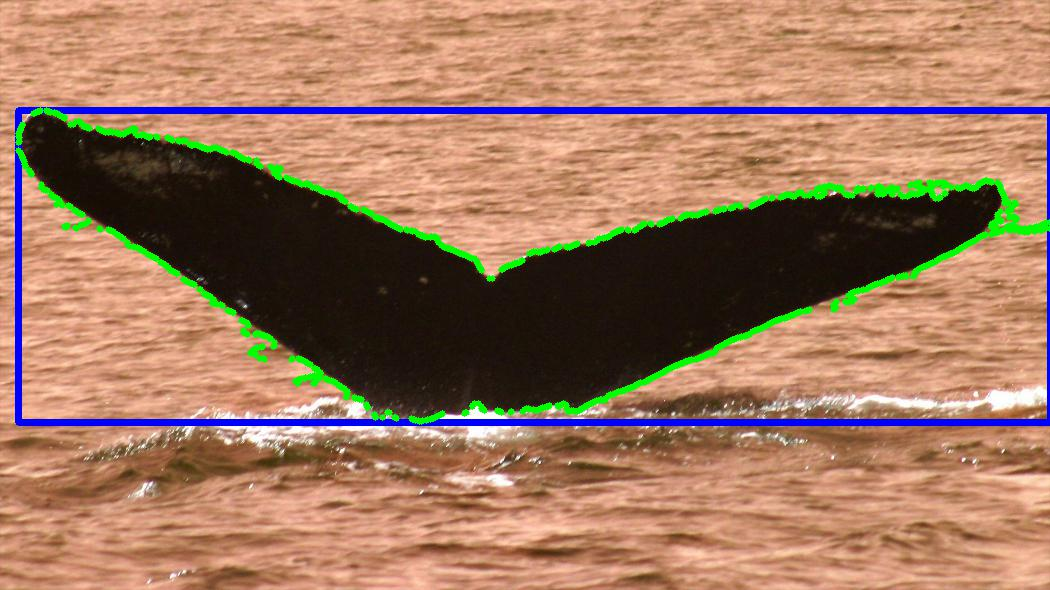

Cropped


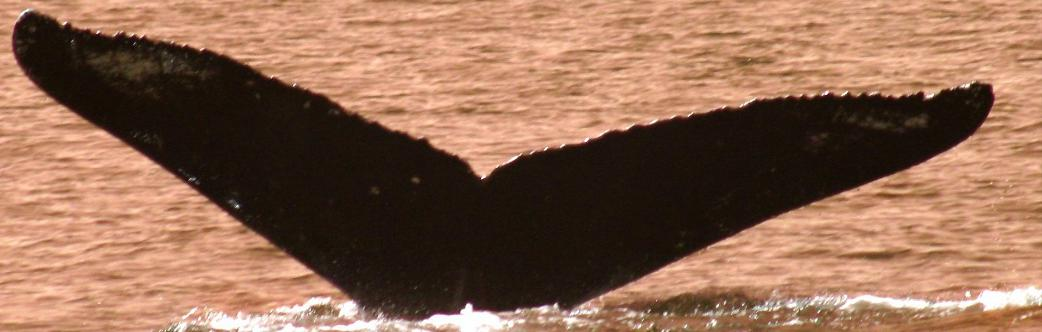

In [20]:
filename = os.path.join(DATA_FOLDER, 'train', train_filenames[0])
img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
contour = get_large_contour(filename)

cropped_img = crop_contour(img, contour).copy()
x, y, w, h = cv2.boundingRect(contour)
img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 5)   
img = cv2.drawContours(img, contour, -1, (0, 255, 0), 5)   
print("Original")
showarray(img)
print("Cropped")
showarray(cropped_img)

In [46]:
# Data preprocessing

from tqdm import tqdm
import humanize

train_x_dim = 500
train_y_dim = 500

saved_data_filename = os.path.join(DATA_FOLDER, 'cropped_tails.npy')

if not os.path.isfile(saved_data_filename):
    train_set = np.empty((len(train_filenames), train_x_dim, train_y_dim, 1), dtype=np.double)
    for i in tqdm(range(len(train_filenames))):
        filename = os.path.join(DATA_FOLDER, 'train', train_filenames[i])
        train_set[i] = get_input_vector(filename, train_x_dim, train_y_dim)
    print("Saving training set...")
    np.save(saved_data_filename, train_set)
    print("{} -> {}".format(saved_data_filename, humanize.naturalsize(os.stat(saved_data_filename).st_size)))
else:
    print("{} already exists".format(saved_data_filename))
    train_set = np.load(saved_data_filename)
    
train_set.shape

100%|██████████| 15697/15697 [05:12<00:00, 50.29it/s]


Saving training set...
data/cropped_tails.npy -> 31.4 GB


In [49]:
# Aligning labels according to the order of training set records
train_labels_ordered = np.empty(train_labels.shape, dtype=train_labels.dtype)
for i, train_filename in tqdm(enumerate(train_filenames)):
    train_labels_ordered[i] = train_labels[train_labels['filename'] == train_filename]
    
assert train_filenames[:10] == train_labels_ordered['filename'].tolist()[:10]

15697it [00:02, 5881.21it/s]


In [50]:
# One-hot encoding

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(train_labels_ordered['whale_id'])
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

assert onehot_encoded.shape == (len(train_labels_ordered), len(np.unique(train_labels_ordered['whale_id'])))

[ 608  940 2316 ... 3070 4431 4502]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/Users/oleg/.pyenv/versions/3.7.1/envs/humpback/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [51]:
# Splitting into train/test/validation sets

# TODO: Shuffle first!!!

import math

train_set_size = int(math.floor(len(train_set) * 0.8))
test_set_size = valid_set_size = (len(train_set) - train_set_size) // 2

# TODO: Shuffle this first
sub_train_set = train_set[:train_set_size]
sub_train_labels = onehot_encoded[:train_set_size]
valid_set = train_set[train_set_size:train_set_size+valid_set_size]
valid_labels = onehot_encoded[train_set_size:train_set_size+valid_set_size]
test_set = train_set[train_set_size+valid_set_size:]
test_labels = onehot_encoded[train_set_size+valid_set_size:]

assert len(sub_train_set) + len(valid_set) + len(test_set) == len(train_set) 
assert len(sub_train_labels) + len(valid_labels) + len(test_labels) == len(onehot_encoded) 

In [55]:
# Building the model

from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

def get_model_fine_to_coarse(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=4, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=4))
    model.add(Conv2D(filters=64, kernel_size=8, padding='valid', activation='relu'))
    model.add(AveragePooling2D(pool_size=8))
    model.add(Conv2D(filters=128, kernel_size=16, padding='same', activation='relu'))
    model.add(GlobalAveragePooling2D())
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = get_model_fine_to_coarse((train_x_dim, train_y_dim, 1), num_classes=len(np.unique(train_labels_ordered['whale_id'])))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 499, 499, 16)      80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 246, 246, 32)      8224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 54, 54, 64)        131136    
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 128)         2097280   
__________

In [56]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
# Training the model

from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)
early_stop = EarlyStopping(patience=5, verbose=1)

model.fit(sub_train_set, sub_train_labels, 
          validation_data=(valid_set, valid_labels),
          epochs=epochs, batch_size=200, callbacks=[checkpointer, early_stop], verbose=1)

Train on 12557 samples, validate on 1570 samples
Epoch 1/10
 3600/12557 [=======>......................] - ETA: 29:22 - loss: 8.4763 - acc: 0.0025

KeyboardInterrupt: 

In [25]:
# Testing the model

print(model.metrics_names)
model.evaluate(test_set, test_labels)

['loss', 'acc']
1570/1570 [==============================] - 11s 7ms/step


[8.267160603954533, 0.016560509554140127]